PREDICTING POTASSIUM - CLASSIFICATION SETUP

---



### 1. Google Colab runtime setup [Optional]

In [ ]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

!pip install shap

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [4]:
# Create configuration file
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [1]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, load_data)
from spectrai.vis.spectra import (plot_spectra)
from spectrai.features.preprocessing import (TakeDerivative, SNV, DropSpectralRegions)

import pandas as pd
import numpy as np

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.covariance import MinCovDet

import xgboost as xgb

import shap

import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

### 3. Load KSSL dataset

In [2]:
%%time
# Loading Potassium, NH4OAc
X, X_names, y, y_names, instances_id = load_data(725)

CPU times: user 24.3 s, sys: 4.64 s, total: 28.9 s
Wall time: 29.7 s


In [3]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)

print('Target variable: ', y_names)

X shape:  (50392, 1764)
X approx. memory size: 355 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


### 4. Plotting spectra

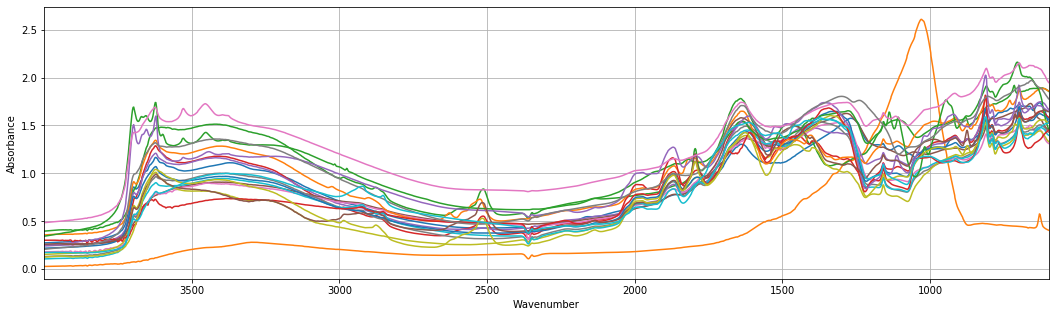

In [4]:
# Quick plot of some spectra
plot_spectra(X, X_names, sample=20)

### 5. Exploratory Data Analysis and Cleaning

In [28]:
detection_limit = 0.03 # (in cmol/kg. According to Tetsuya (Rich's USDA file mentions 0.3 cmol/kg)

# How many samples above detection limit of K (725)?
print('# samples > detection limit: {:.2f}%'.format(100 * sum(y[:, -1] >= detection_limit)/y.shape[0]))

# Select only value samples
valid_idx = y[:, -1] >= detection_limit
X_valid , y_valid, instances_id_valid =  X[valid_idx, :], y[valid_idx, :], instances_id[valid_idx]

# samples > detection limit: 93.38%


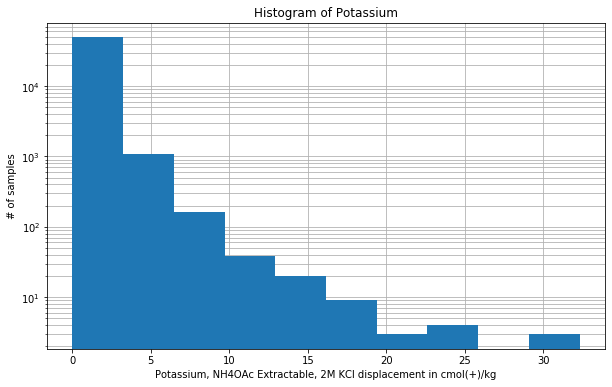

In [6]:
# Histogram of K
fig, ax = plt.subplots(figsize=(10, 6))
plt.xlabel('Potassium, NH4OAc Extractable, 2M KCl displacement in cmol(+)/kg')
plt.ylabel('# of samples')
plt.title('Histogram of Potassium')
ax.grid(True, which='both')
ax.set_axisbelow(True)
ax.hist(y[:, -1], bins=10, log=True, histtype='bar', cumulative=False);

In [8]:
# Some summary Statistics
np.percentile(y[:, -1], [25, 50, 75, 99.9])

array([ 0.15513592,  0.3616932 ,  0.74446868, 11.34359438])

* **Visualizing spectrum in PCA space**

In [9]:
# Define the PCA object
n_components = 20
pca = PCA(n_components=n_components)

T = pca.fit_transform(TakeDerivative().fit_transform(SNV().fit_transform(X_valid)))

In [10]:
def plot_explained_variance(pca, title='', figsize=(12, 6)):
    n_components = len(pca.explained_variance_ratio_)
    cumsum = np.cumsum(pca.explained_variance_ratio_)
    accent_color = 'firebrick'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    ax.set_ylabel('Explained variance')
    ax.set_xlabel('Nb. of PCA components')
    ax.grid(True, which='both')
    ax.set_xticks(range(1, n_components+1))
    ax.set_axisbelow(True)
    ax.bar(range(1, n_components+1), pca.explained_variance_ratio_, color='steelblue')
    
    ax_twin = ax.twinx()
    ax_twin.set_ylabel('Cumulated Explained Variance', color=accent_color)
    ax_twin.tick_params('y', colors=accent_color) 
    ax_twin.plot(range(1, n_components+1), cumsum, color=accent_color, lw=2)   

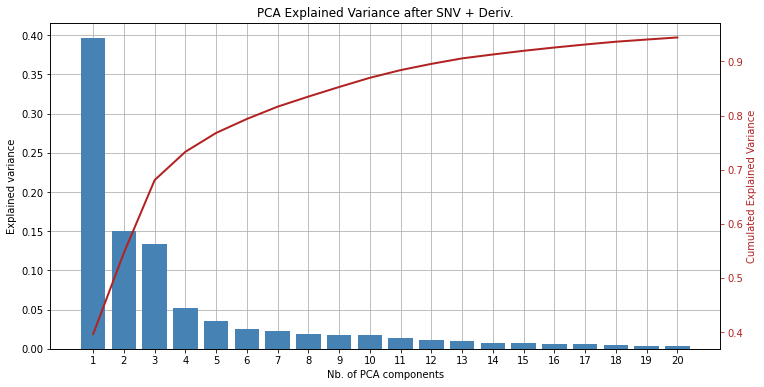

In [11]:
plot_explained_variance(pca, 'PCA Explained Variance after SNV + Deriv.')

In [12]:
nb_pc = 10
# fit a Minimum Covariance Determinant (MCD) robust estimator to data 
robust_cov = MinCovDet().fit(T[:, :nb_pc])
# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:,:nb_pc])

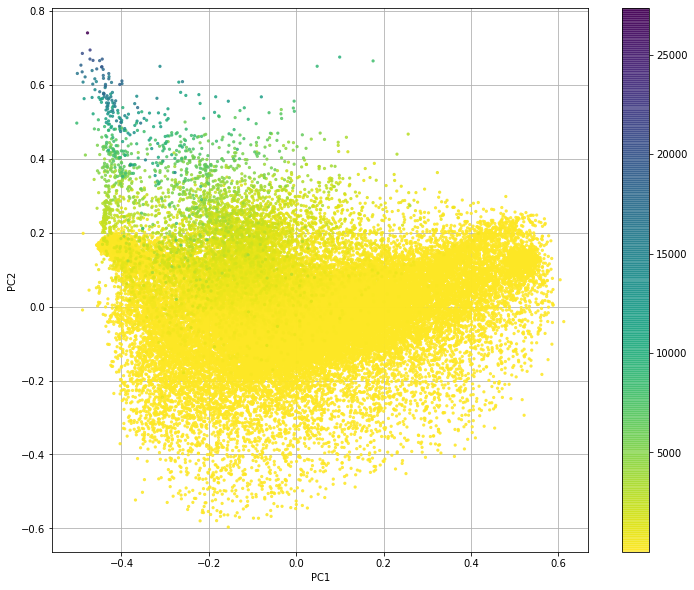

In [13]:
# Score plot of the first 2 PC colored with Mahalanobis distance using the five first PCs
fig, ax = plt.subplots(figsize=(12, 10))
 
cpt_x, cpt_y = 0, 1
sc = ax.scatter(T[np.argsort(m), cpt_x], T[np.argsort(m), cpt_y], c=np.abs(np.sort(m)), cmap='viridis_r', edgecolors=None, s=5, alpha=0.8)
plt.xlabel('PC{}'.format(cpt_x+1))
plt.ylabel('PC{}'.format(cpt_y+1))
ax.set_axisbelow(True)
ax.grid(True, which='both')
plt.colorbar(sc);

In [14]:
valid_idx = m < np.percentile(m, 99)
X_valid , y_valid, instances_id_valid =  X_valid[valid_idx, :], y_valid[valid_idx, :], instances_id_valid[valid_idx]

### 6. Predict

In [7]:
# Discretize

#nb_classes = 2
#discretizer = KBinsDiscretizer(n_bins=nb_classes, encode='ordinal', strategy='quantile')
#y_b = discretizer.fit_transform(y[:, -1].reshape(-1, 1))

threshold, low, high = 0.425, 0, 1
y_b = np.where(y_valid[:, -1] > threshold, high, low)

In [8]:
# Train, test split
X_train, X_test, y_train, y_test, smp_id_train, smp_id_test = train_test_split(X_valid, y_b, instances_id_valid,
                                                                               stratify=y_b, 
                                                                               test_size=0.2, 
                                                                               random_state=42)
print('X_train shape: ', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape:  (22769, 1764)
X_test shape:  (5693, 1764)


#### Logistic Regression

In [9]:
# Hyperparameter grid
co2_region = [2389,  2269]

param_grid = {'model__C': [0.1, 0.5, 1, 5, 10]}
param_grid = {'model__C': [50]}

# Setup and fit the pipeline
pipe = Pipeline([('snv', SNV()),
                 ('derivative', TakeDerivative()), 
                 ('dropper', DropSpectralRegions(X_names, regions=co2_region)),
                 ('model', LogisticRegression(max_iter=2000, multi_class='auto', penalty='l2'))])

grid_search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy', return_train_score=True, verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('snv', SNV()),
                                       ('derivative', TakeDerivative()),
                                       ('dropper',
                                        DropSpectralRegions(wavenumbers=array([3999, 3997, 3995, ...,  603,  601,  599], dtype=int32))),
                                       ('model',
                                        LogisticRegression(max_iter=2000))]),
             param_grid={'model__C': [50]}, return_train_score=True,
             scoring='accuracy')

In [272]:
# Best score on valid. set
grid_search.best_score_

0.8194381093725898

In [273]:
# Score of best estimator on training set
grid_search.best_estimator_.score(X_train,y_train)

0.824214452464647

In [274]:
# Score of best estimator on test set
grid_search.best_estimator_.score(X_test,y_test)

0.8208650853278953

In [9]:
def plot_along_wn(X, X_names, y_label='Absorbance', title='Weights', figsize=(22, 5)):   
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_xlim(np.max(X_names), np.min(X_names))
    plt.xlabel('Wavenumber')
    plt.ylabel(y_label)
    ax.grid(True, which='both')
    ax.set_axisbelow(True)
    plt.title(title)
    _ = ax.plot(X_names, X)

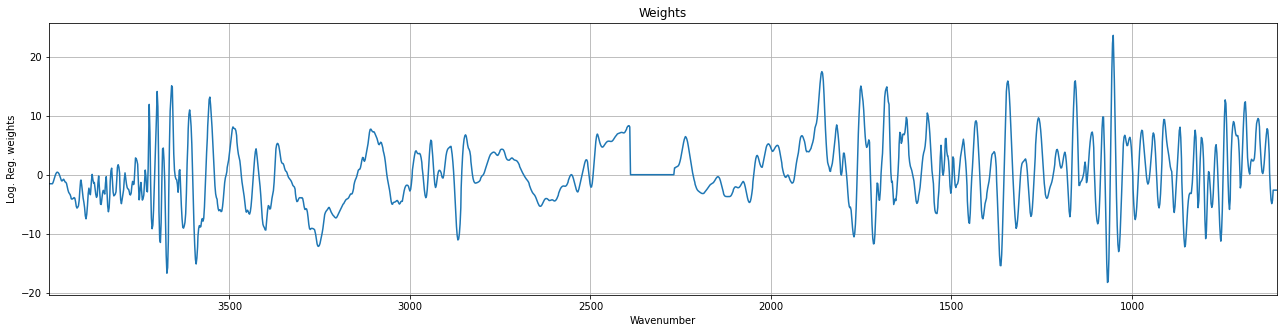

In [276]:
plot_along_wn(grid_search.best_estimator_['model'].coef_.ravel(), X_names, y_label='Log. Reg. weights')

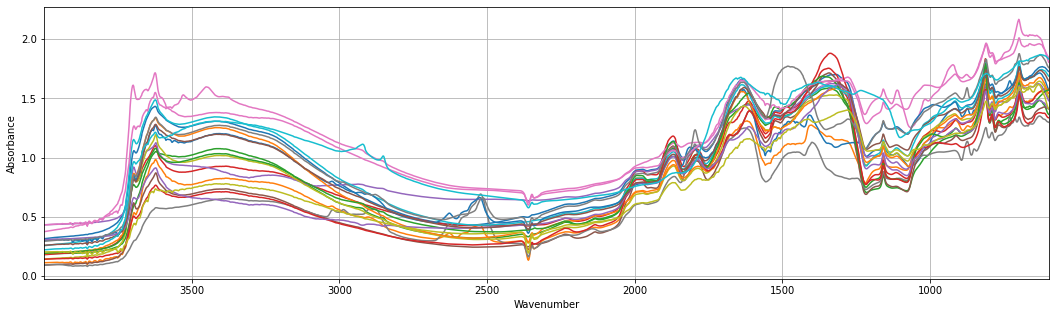

In [23]:
plot_spectra(X, X_names, sample=20)

In [ ]:
y_train_pred = cross_val_predict(grid_search.best_estimator_, X_train, y_train, cv=5, method='decision_function')

In [ ]:
fpr, tpr, thresholds = roc_curve(y_train, y_train_pred, drop_intermediate=True)

In [44]:
def optimal_roc_cutoff(tpr, fpr, thresholds):
    probs = [to_prob(t) for t in thresholds]
    opt_idx = np.abs(tpr-(1-fpr)).argsort()[:1].item()
    return tpr[opt_idx], fpr[opt_idx], probs[opt_idx]

def to_prob(score):
    return 1/ (1 + np.exp(score))

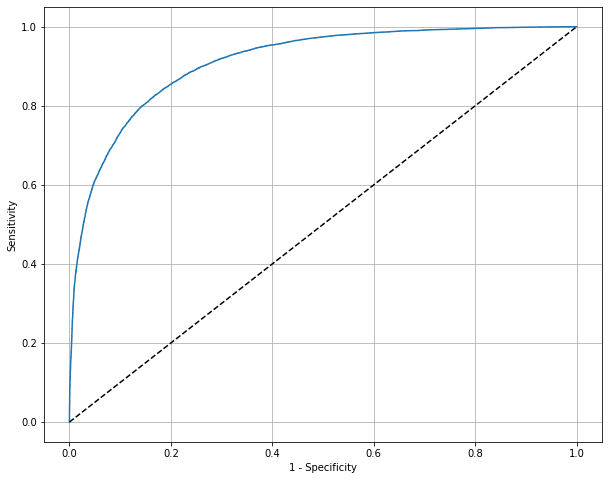

In [ ]:
def plot_roc_curve(fpr, tpr, label=None, title=None, figsize=(10, 8)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.xlabel('1 - Specificity')
    plt.ylabel('Sensitivity')
    ax.grid(True, which='both')
    ax.set_axisbelow(True)
    plt.title(title)
    ax.plot(fpr, tpr, label=label)
    ax.plot([0, 1], [0, 1], 'k--') # dashed diagonal

plot_roc_curve(fpr, tpr)

In [ ]:
opt_tpr, opt_fpr, opt_prob_threshold = optimal_roc_cutoff(tpr, fpr, thresholds)
print('Optimal probability threshold: {:.2f}'.format(opt_prob_threshold))

Optimal probability threshold: 0.54


In [ ]:
roc_auc_score(y_train, y_train_pred)

0.9115792601337911

#### XG-Boost

In [31]:
co2_region = [2389,  2269]

# Hyperparameter grid
param_grid = {'model__eta': [0.05, 0.1, 0.3, 0.6], 'model__max_depth': [2, 4, 6, 8]}

# Setup and fit the pipeline
pipe = Pipeline([('snv', SNV()),
                 ('derivative', TakeDerivative()), 
                 ('dropper', DropSpectralRegions(X_names, regions=co2_region)),
                 ('model', xgb.XGBClassifier(objective='binary:logistic', n_estimators=2000, tree_method='gpu_hist'))])

grid_search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy', return_train_score=True, verbose=0)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=2,
             estimator=Pipeline(steps=[('snv', SNV()),
                                       ('derivative', TakeDerivative()),
                                       ('dropper',
                                        DropSpectralRegions(wavenumbers=array([3999, 3997, 3995, ...,  603,  601,  599], dtype=int32))),
                                       ('model',
                                        XGBClassifier(n_estimators=2000,
                                                      tree_method='gpu_hist'))]),
             param_grid={'model__eta': [0.05, 0.1, 0.3, 0.6],
                         'model__max_depth': [2, 4, 6, 8]},
             return_train_score=True, scoring='accuracy')

In [37]:
grid_search.best_params_

{'model__eta': 0.05, 'model__max_depth': 8}

In [38]:
# Best score on valid. set
grid_search.best_score_

0.8706566783551164

In [39]:
# Score of best estimator on training set
grid_search.best_estimator_.score(X_train,y_train)

1.0

In [40]:
# Score of best estimator on training set
grid_search.best_estimator_.score(X_test,y_test)

0.8805652959302943

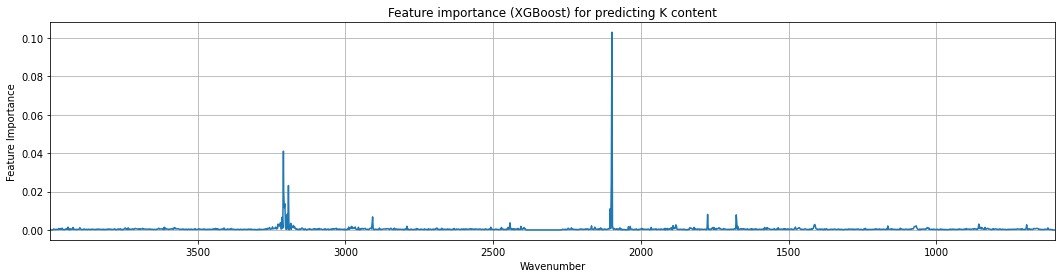

In [41]:
plot_along_wn(grid_search.best_estimator_['model'].feature_importances_, 
              X_names, y_label='Feature Importance', title='Feature importance (XGBoost) for predicting K content', figsize=(18, 4))

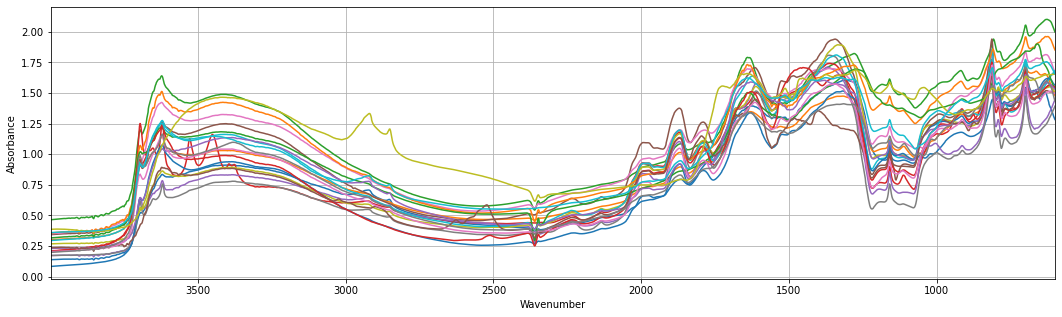

In [42]:
plot_spectra(X, X_names, sample=20)

In [ ]:
explainer = shap.TreeExplainer(grid_search.best_estimator_['model'])
shap_values = explainer.shap_values(X_test)

### 8. Which threshold for low, high?

In [47]:
def assess_thresholds(X, y, thresholds=[0.425], model_selection=None, random_state=42):
    assert np.min(thresholds) > np.min(y), 'Lower threshold should be higher than y min. value'
    assert np.max(thresholds) < np.max(y) , 'Higher threshold should be lower than y max value'

    for threshold in thresholds:
        y_b = np.where(y > threshold, 1, 0) # High is 1, Low is 0 
        X_train, X_test, y_train, y_test = train_test_split(X, y_b,stratify=y_b, 
                                                            test_size=0.2, random_state=random_state)
        model_selection.fit(X_train, y_train)
        y_train_pred = cross_val_predict(model_selection.best_estimator_, X_train, y_train, cv=5, method='decision_function')
        fpr, tpr, decision_thresholds = roc_curve(y_train, y_train_pred, drop_intermediate=True)
        opt_tpr, opt_fpr, opt_prob_threshold = optimal_roc_cutoff(tpr, fpr, decision_thresholds)
        history.append(
            {'threshold': threshold, 
             'fpr': fpr, 
             'tpr': tpr,
             'decision_thresholds': decision_thresholds, 
             'opt_tpr': opt_tpr,
             'opt_fpr': opt_fpr,
             'opt_prob_tresholds': opt_prob_threshold,
             'auc': roc_auc_score(y_train, y_train_pred), 
             'best_params': model_selection.best_params_})
    
    return history

In [48]:
history = []

# Hyperparameter grid for Logistic Regression
co2_region = [2389,  2269]
param_grid = {'model__C': [50]}

# Setup and fit the pipeline
pipe = Pipeline([('snv', SNV()),
                 ('derivative', TakeDerivative()), 
                 ('dropper', DropSpectralRegions(X_names, regions=co2_region)),
                 ('model', LogisticRegression(max_iter=2000, multi_class='auto', penalty='l2'))])

grid_search = GridSearchCV(pipe, param_grid, cv=2, scoring='accuracy', return_train_score=True, verbose=0)

thresholds = [i/10 for i in range(1,11)]

assess_thresholds(X_valid, y_valid[:, -1], thresholds=thresholds, model_selection=grid_search)

[{'threshold': 0.1,
  'fpr': array([0.        , 0.        , 0.        , ..., 0.99951574, 0.99951574,
         1.        ]),
  'tpr': array([0.00000000e+00, 2.98382765e-05, 4.62493286e-03, ...,
         9.99970162e-01, 1.00000000e+00, 1.00000000e+00]),
  'decision_thresholds': array([14.1217837 , 13.1217837 ,  7.57180845, ..., -2.82453981,
         -2.8316119 , -3.35131066]),
  'opt_tpr': 0.8204332517753774,
  'opt_fpr': 0.17966101694915254,
  'opt_prob_tresholds': 0.13466679843596743,
  'auc': 0.8991550782651492,
  'best_params': {'model__C': 50}},
 {'threshold': 0.2,
  'fpr': array([0.        , 0.        , 0.        , ..., 0.99920643, 0.99920643,
         1.        ]),
  'tpr': array([0.00000000e+00, 3.62805210e-05, 7.98171462e-03, ...,
         9.99963719e-01, 1.00000000e+00, 1.00000000e+00]),
  'decision_thresholds': array([16.31713664, 15.31713664,  6.07907289, ..., -5.56167543,
         -5.84434704, -8.60449913]),
  'opt_tpr': 0.8234589848710228,
  'opt_fpr': 0.176569784743577,
  

### 9. Error analysis

In [43]:
# Get predictions probabilities
y_hat_prob = grid_search.best_estimator_.predict_proba(X_test)

In [44]:
y_test_c = y[[np.argwhere(instances_id == i)[0].item() for i in smp_id_test], -1]

In [45]:
# Is there any  
df_error_analysis = pd.DataFrame(np.c_[y_hat_prob[:, :], y_test, smp_id_test, y_test_c], 
                                 columns=['prob_low', 'prob_high', 'ground_truth', 'smp_id', 'y_continuous'])

df_error_analysis['smp_id'] = df_error_analysis['smp_id'].astype('int')
df_error_analysis.head()

,prob_low,prob_high,ground_truth,smp_id,y_continuous
0,0.986017,0.013983,1.0,64352,0.463356
1,0.999972,0.000028,0.0,262789,0.070055
2,0.999986,0.000014,0.0,276947,0.058702
3,0.942403,0.057597,1.0,73779,0.693666
4,0.000033,0.999967,1.0,188576,3.212017


In [ ]:
# Ok, I want to plot spectrum for "strong" TP, FN, FP, TN (erroneous certainty)

In [54]:
(534+538) /(3858 + 4437)

0.1292344786015672

count    3858.000000
mean        1.377866
std         1.420834
min         0.425129
25%         0.635436
50%         0.917211
75%         1.536929
max        22.699366
Name: y_continuous, dtype: float64

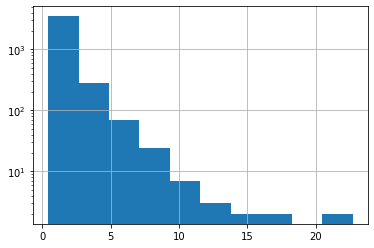

In [46]:
# TP
mask_TP = (df_error_analysis['ground_truth'] == 1) & (df_error_analysis['prob_high'] > 0.54)
df_TP = df_error_analysis[mask_TP]

df_TP['y_continuous'].hist(log=True)
df_TP['y_continuous'].describe()

count    4437.000000
mean        0.197609
std         0.104968
min         0.030300
25%         0.112135
50%         0.183175
75%         0.278517
max         0.424934
Name: y_continuous, dtype: float64

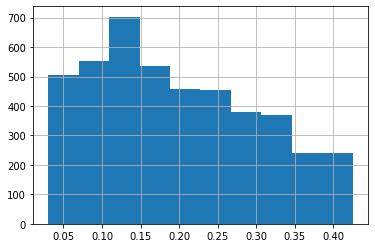

In [47]:
# TN
mask_TN = (df_error_analysis['ground_truth'] == 0) & (df_error_analysis['prob_high'] < 0.54)
df_TN = df_error_analysis[mask_TN]

df_TN['y_continuous'].hist()
df_TN['y_continuous'].describe()

count    534.000000
mean       0.647971
std        0.526718
min        0.425116
25%        0.463331
50%        0.524910
75%        0.645390
max        9.224717
Name: y_continuous, dtype: float64

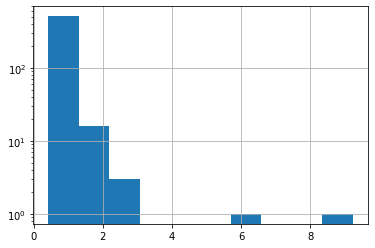

In [48]:
# FN
mask_FN = (df_error_analysis['ground_truth'] == 1) & (df_error_analysis['prob_low'] > 0.54)
df_FN = df_error_analysis[mask_FN]

df_FN['y_continuous'].hist(log=True)
df_FN['y_continuous'].describe()

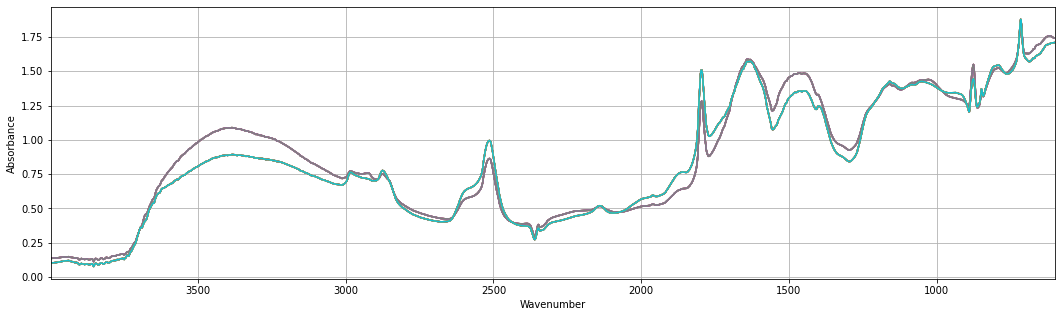

In [49]:
df_error_analysis[(df_error_analysis['ground_truth'] == 1) & 
                  (df_error_analysis['prob_low'] > 0.54) &
                  (df_error_analysis['y_continuous'] > 5)]['smp_id'].to_numpy()

plot_spectra(X[[np.argwhere(instances_id == i)[0].item() for i in [256376, 256377]], :], X_names, sample=20)

count    538.000000
mean       0.321653
std        0.085361
min        0.045332
25%        0.271679
50%        0.340987
75%        0.389002
max        0.424954
Name: y_continuous, dtype: float64

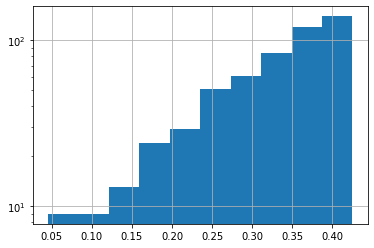

In [50]:
# FP
mask_FP = (df_error_analysis['ground_truth'] == 0) & (df_error_analysis['prob_high'] > 0.54)
df_FP = df_error_analysis[mask_FP]

df_FP['y_continuous'].hist(log=True)
df_FP['y_continuous'].describe()

* **Exploring TN, TP, ... spectral features**

In [51]:
# Encoding confusion matrix as a single vector
conf_entry = np.empty_like(mask_TN, dtype=np.int)
masks = [mask_TP, mask_FP, mask_FN, mask_TN]
for i, mask in enumerate(masks):
    conf_entry[mask] = i

In [52]:
# Define the PCA object
n_components = 20
pca = PCA(n_components=n_components)

T = pca.fit_transform(SNV().fit_transform(X_test))

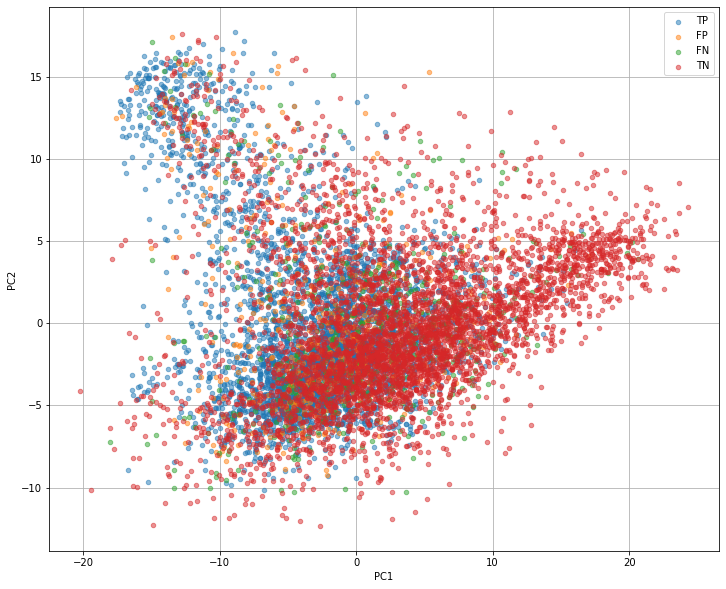

In [53]:
# Score plot of the first 2 PC colored with confusion matrix
fig, ax = plt.subplots(figsize=(12, 10))
 
label_colors_masks = zip(['TP', 'FP', 'FN', 'TN'], 
                         ['tab:blue', 'tab:orange', 'tab:green', 'tab:red'],
                         masks)
cpt_x, cpt_y = 0, 1
for label, color, mask in label_colors_masks:
    ax.scatter(T[mask, cpt_x], T[mask, cpt_y], c=color, label=label, edgecolors=None, s=20, alpha=0.5)
plt.xlabel('PC{}'.format(cpt_x+1))
plt.ylabel('PC{}'.format(cpt_y+1))
ax.set_axisbelow(True)
ax.grid(True, which='both')
plt.legend();

### 9. SHAP values

In [ ]:
# use Kernel SHAP to explain test set predictions
explainer = shap.KernelExplainer(grid_search.best_estimator_.predict_proba, X_train[:100, :], link="logit")

In [ ]:
shap_values = explainer.shap_values(X_test[mask_TP,:][:2,:], nsamples=100)

Regressors in active set degenerate. Dropping a regressor, after 5 iterations, i.e. alpha=3.112e-01, with an active set of 5 regressors, and the smallest cholesky pivot element being 1.490e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 85 iterations, i.e. alpha=9.205e-02, with an active set of 21 regressors, and the smallest cholesky pivot element being 2.980e-08. Reduce max_iter or increase eps parameters.
Regressors in active set degenerate. Dropping a regressor, after 91 iterations, i.e. alpha=9.188e-02, with an active set of 23 regressors, and the smallest cholesky pivot element being 1.054e-08. Reduce max_iter or increase eps parameters.
Early stopping the lars path, as the residues are small and the current value of alpha is no longer well controlled. 93 iterations, alpha=9.187e-02, previous alpha=9.143e-02, with an active set of 24 regressors.
Regressors in active set degenerate. Dropping a regressor, after 5 ite

In [ ]:
shap_values[0].shape

(2, 1764)

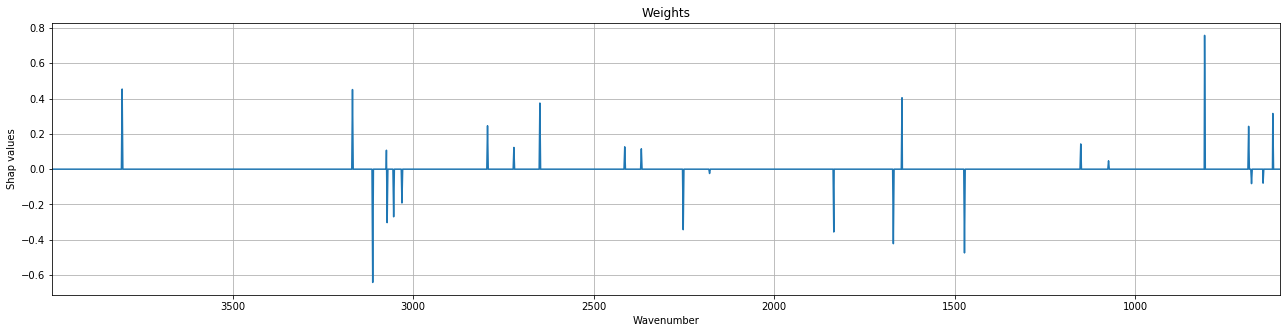

In [ ]:
plot_along_wn(shap_values[1][0], X_names, y_label='Shap values')

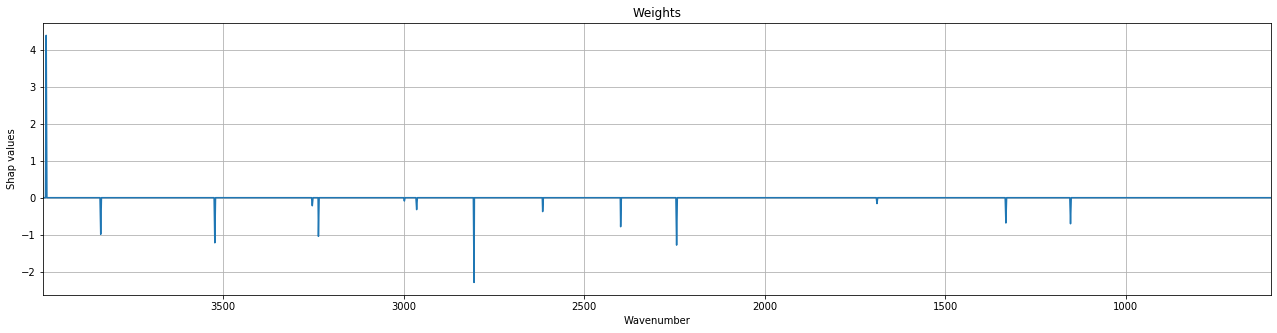

In [ ]:
plot_along_wn(shap_values[0][1], X_names, y_label='Shap values')

In [ ]:
def plot_shap(shap_values, X, X_names,
              y_hat, y_true,
              class_label=['LOW', 'HIGH'], 
              figsize=(25, 16), accent_color='firebrick'):
  nb_spectra = X.shape[0]
  nb_classes = len(shap_values)
  min_shap, max_shap = np.min(shap_values), np.max(shap_values)
  fig, ax = plt.subplots(nb_spectra, nb_classes + 1, sharey='col', figsize=figsize)
  for row in range(nb_spectra):
    for col in range(nb_classes +1):
      # Plot spectra
      ax[row, col].set_xlim(np.max(X_names), np.min(X_names))
      alpha = 1 if col == 0 else 0.2 
      ax[row, col].plot(X_names, X[row], color='black', alpha=alpha)
      ax[row, col].spines['top'].set_visible(False)
      ax[row, col].spines['right'].set_visible(False)
      ax[row, col].spines['left'].set_visible(False)
      ax[row, col].spines['bottom'].set_visible(False)
      ax[row, col].get_yaxis().set_visible(False) 
      
      if row == 0:
        label = 'Spectra' if col == 0 else class_label[col-1]  
        ax[row, col].set_title(label)

      if row == nb_spectra - 1:
        ax[row, col].set_xlabel('Wavenumber')

      if col == 0:
        ax[row, col].annotate('Ground truth: {}'.format(class_label[y_true[row]]), xy=[0, 0.8], xycoords='axes fraction', color='steelblue')

      # Plot SHAP values
      if col >= 1:
        ax_twin = ax[row, col].twinx()
        ax_twin.set_ylim(min_shap, max_shap)
        ax_twin.spines['top'].set_visible(False)
        ax_twin.spines['right'].set_visible(False)
        ax_twin.spines['left'].set_visible(False)
        ax_twin.spines['bottom'].set_visible(False)
        ax_twin.tick_params('y', colors=accent_color) 
        ax_twin.plot(X_names, shap_values[col - 1][row], color=accent_color, alpha=0.6, linewidth=1)
        if col == nb_classes:
          ax_twin.set_ylabel('SHAP value', color=accent_color)
        ax[row, col].annotate('Probability : {:.2f}'.format(y_hat[row, col - 1]), xy=[0, 0.8], xycoords='axes fraction', color='steelblue')

  
  plt.show()

In [ ]:
y_test[mask_TP][:2]

array([1, 1])

IndexError: too many indices for array

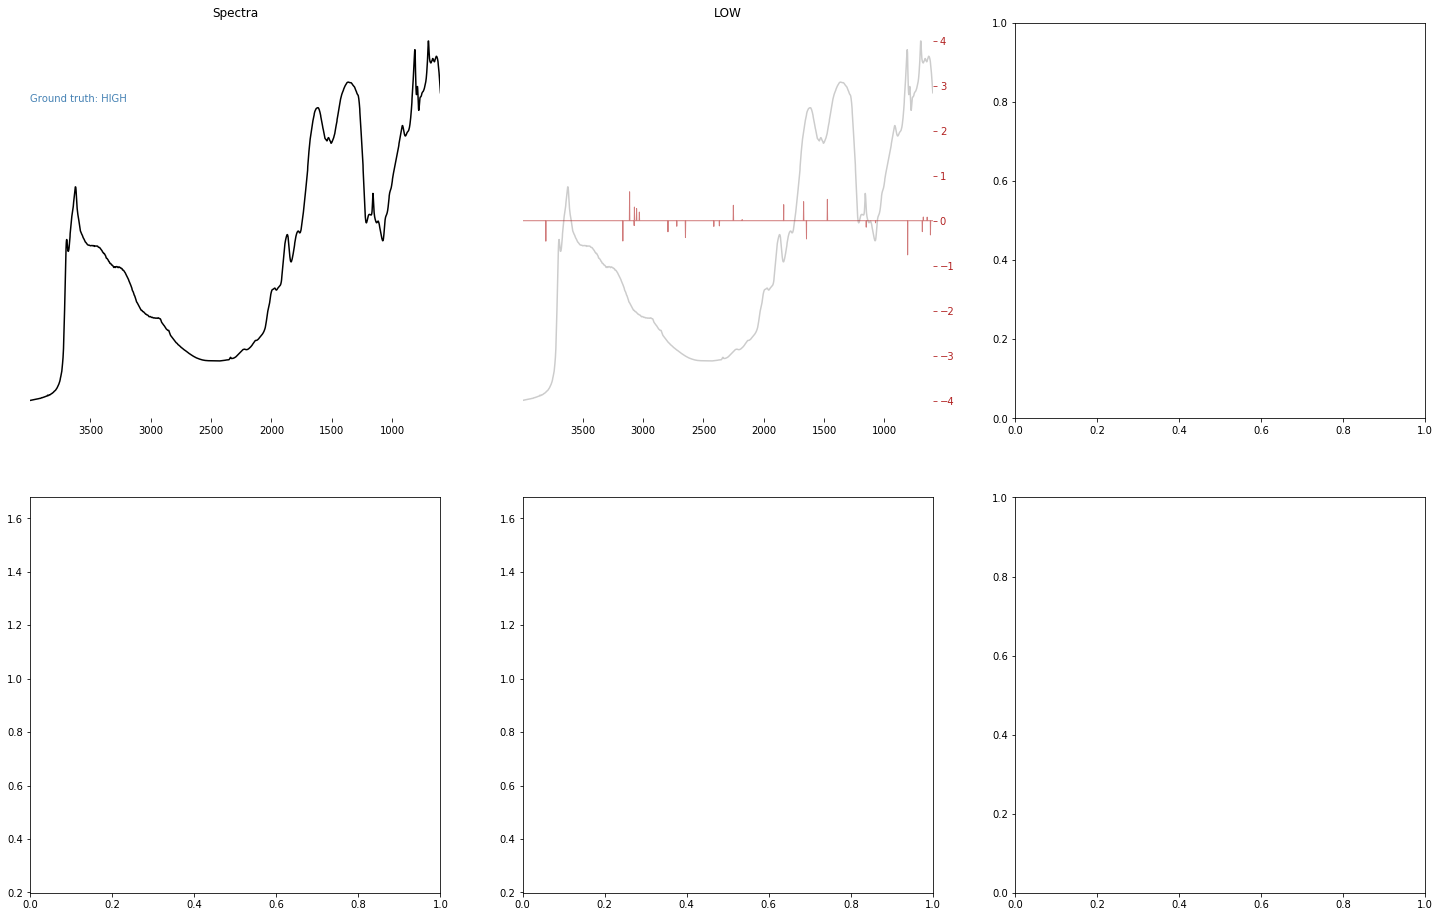

In [ ]:
X_shap_test = X_test[mask_TP,:][:2,:]

plot_shap(shap_values, 
          X_shap_test,
          X_names, 
          grid_search.best_estimator_.predict(X_shap_test), 
          y_test[mask_TP][:2])